In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm

# **Phase 1**

1. Data Processing & Feature Engineering

In [12]:
# Define column names for the dataset
columns = ['Engine_ID', 'Cycle', 'Setting_1', 'Setting_2', 'Setting_3'] + [f'Sensor_{i}' for i in range(1, 22)]

In [13]:
# Load training and test datasets
train_df = pd.read_csv("train_FD001.txt", sep=" ", header=None, names=columns, engine='python')
test_df = pd.read_csv("test_FD001.txt", sep=" ", header=None, names=columns, engine='python')
rul_df = pd.read_csv("RUL_FD001.txt", sep=" ", header=None, names=['RUL'])

In [14]:
# Clean dataset (remove empty columns due to extra spaces in txt file)
train_df = train_df.dropna(axis=1, how='all')
test_df = test_df.dropna(axis=1, how='all')

In [15]:
# Feature Engineering: Create RUL Target Column
train_df['RUL'] = train_df.groupby('Engine_ID')['Cycle'].transform(lambda x: max(x) - x)

In [16]:
# Create additional time-based features
train_df['Cycle_Squared'] = train_df['Cycle'] ** 2
test_df['Cycle_Squared'] = test_df['Cycle'] ** 2

In [17]:
print(train_df.columns)

Index(['Engine_ID', 'Cycle', 'Setting_1', 'Setting_2', 'Setting_3', 'Sensor_1',
       'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7',
       'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12',
       'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17',
       'Sensor_18', 'Sensor_19', 'RUL', 'Cycle_Squared'],
      dtype='object')


In [18]:
# Handle anomalous values by clipping extreme sensor readings
for col in [f'Sensor_{i}' for i in range(1, 20)]:
    train_df[col] = train_df[col].clip(lower=train_df[col].quantile(0.01), upper=train_df[col].quantile(0.99))
    test_df[col] = test_df[col].clip(lower=test_df[col].quantile(0.01), upper=test_df[col].quantile(0.99))

In [19]:
# Normalize sensor readings
sensor_columns = [f'Sensor_{i}' for i in range(1, 20)]
scaler = StandardScaler()
train_df[sensor_columns] = scaler.fit_transform(train_df[sensor_columns])
test_df[sensor_columns] = scaler.transform(test_df[sensor_columns])

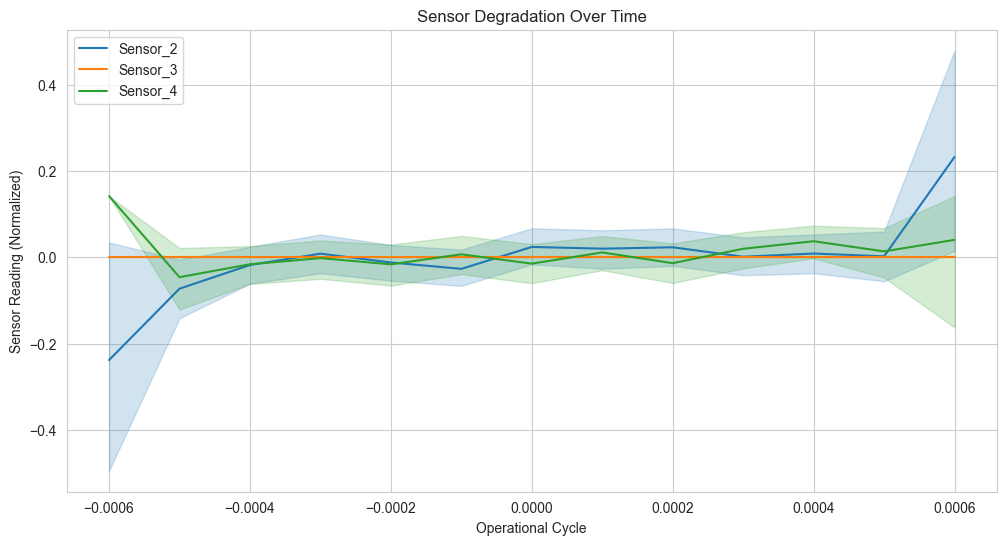

In [20]:
# Analyze Sensor Degradation Patterns
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
for sensor in ['Sensor_2', 'Sensor_3', 'Sensor_4']:
    sns.lineplot(data=train_df, x='Cycle', y=sensor, label=sensor)
plt.title("Sensor Degradation Over Time")
plt.xlabel("Operational Cycle")
plt.ylabel("Sensor Reading (Normalized)")
plt.legend()
plt.show()

2. RUL Prediction Model

In [21]:
  # Prepare Training Data
X = train_df.drop(columns=['Engine_ID', 'Cycle', 'RUL'])
y = train_df['RUL']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Train Random Forest Model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [23]:
# Predict on Validation Data
y_pred = model.predict(X_val)

In [24]:
# Estimate Confidence Intervals
std_dev = np.std(y_pred - y_val)
confidence_interval = norm.interval(0.95, loc=y_pred, scale=std_dev)

3: Model Evaluation & Documentation

In [25]:
# Evaluate Model Performance
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 0.00025632541797916155, RMSE: 0.0003009567008536419


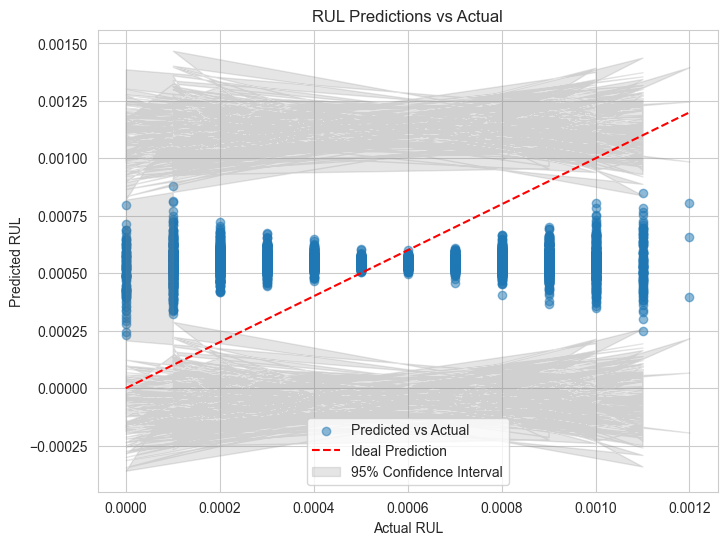

In [26]:
# Plot Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', label='Ideal Prediction')
plt.fill_between(y_val, confidence_interval[0], confidence_interval[1], color='gray', alpha=0.2, label='95% Confidence Interval')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("RUL Predictions vs Actual")
plt.legend()
plt.show()

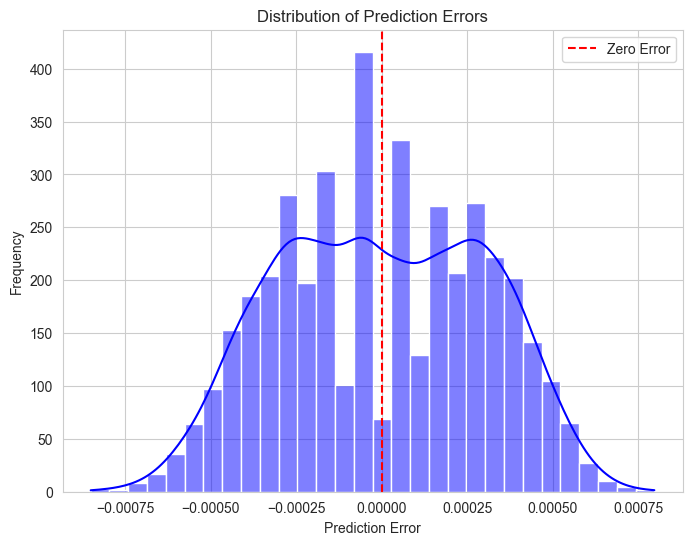

In [27]:
#Histogram of Prediction Errors
plt.figure(figsize=(8, 6))
sns.histplot(y_pred - y_val, bins=30, kde=True, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.legend()
plt.show()

/var/folders/k4/pq3_w6gn1z95f20kz25bgskr0000gn/T/ipykernel_17864/3808245045.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=X.columns, palette='viridis')


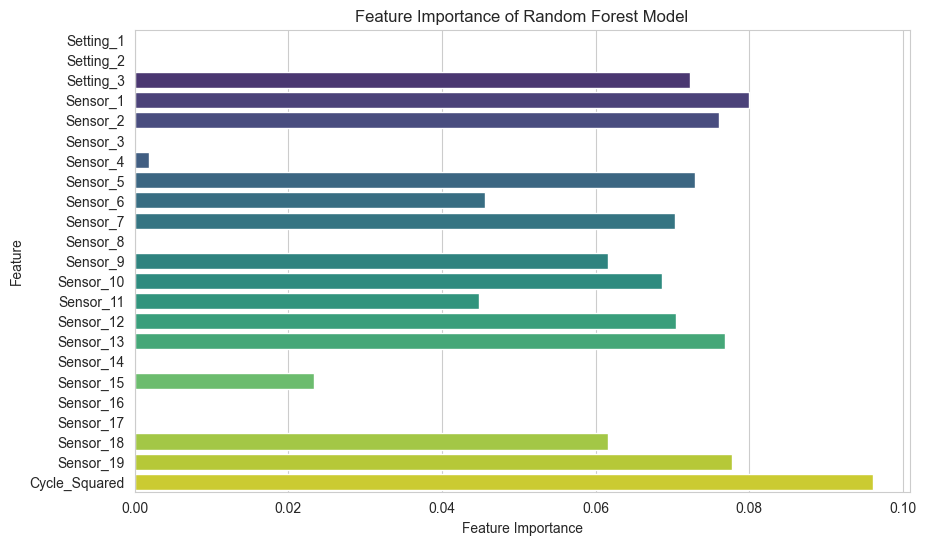

In [28]:
#Feature Importance
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=X.columns, palette='viridis')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance of Random Forest Model")
plt.show()

In [29]:
import joblib

# Save trained RUL prediction model
joblib.dump(model, "rul_model.pkl")
print("✅ RUL model saved as 'rul_model.pkl'")

# Save the StandardScaler used for normalization
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaler saved as 'scaler.pkl'")

✅ RUL model saved as 'rul_model.pkl'
✅ Scaler saved as 'scaler.pkl'


# Example of System Usage in Maintenance Planning:

1. **Preventive Maintenance Scheduling:**

Airlines, manufacturing plants, and power stations can use the RUL predictions to schedule maintenance before a failure occurs.

If an engine’s predicted RUL drops below a critical threshold (e.g., 20 cycles left), maintenance teams can proactively schedule repairs or replacements.

2. **Spare Parts & Resource Optimization:**

Knowing which engines will fail soon helps companies order spare parts in advance, reducing downtime and costs.

Maintenance crews can be allocated efficiently based on expected failures.

3. **Cost Savings & Reliability Improvement:**

Unplanned failures lead to high costs and operational delays. Predicting failures allows businesses to avoid emergency repairs.

Airlines, for example, can prevent mid-air engine failures by ensuring timely maintenance.